In [1]:
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.metrics import roc_auc_score, precision_score, log_loss, accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
def model_lr_gcv(X, y, c):
    start = time.time()
    scorer = {'log_loss': metrics.make_scorer(log_loss, needs_proba = True),
              'precision':metrics.make_scorer(precision_score),
              'roc_auc':metrics.make_scorer(roc_auc_score)}
    kf = KFold(n_splits = 5, shuffle = True)
    parameters = {'C': [c], 'penalty': ['l2'], 
                  'solver': ['sag'], 'max_iter': [500]}
    gcv = GridSearchCV(estimator = LogisticRegression(), param_grid = parameters, 
                       scoring = scorer, refit = 'roc_auc', n_jobs = -1, cv = kf)
    gcv.fit(X, y)
    end = time.time()
    print('Time %d:%d:%f' %(round((end - start)//3600),round((end - start)//60),(end - start) % 60))
    return gcv


def tfidf(X_train, X_test, max_features):
    tfidf_word = TfidfVectorizer(
        analyzer='word',
        max_df = 0.1, 
        ngram_range=(1, 2),
        max_features=max_features)
    tfidf_X = tfidf_word.fit_transform(X['comment_text'])
    tfidf_test_X = tfidf_word.transform(test_X['comment_text'])
    return tfidf_X, tfidf_test_X, tfidf_word

In [3]:
train = pd.read_csv('../datasets/processed_train.csv', index_col='id')
test_X = pd.read_csv('../datasets/processed_test.csv', index_col='id')
test_y = pd.read_csv('../datasets/test_labels.csv', index_col='id')
X = train[['comment_text']]  
y = train[['toxic']] 

In [4]:
C = [10**i for i in range(-1, 4)]

In [5]:
max_features = 40000
tfidf_X, tfidf_test_X, model_tfidf = tfidf(X, test_X, max_features)

In [6]:
#0 - log_loss, 1 - precision, 2 - roc_auc
cv_score = []
test_score = []
lr = None
for i in C:
    print('%f:' % i)
    lr = model_lr_gcv(tfidf_X, y, i)
    pred_y = lr.predict(tfidf_test_X)
    pred_proba = lr.predict_proba(tfidf_test_X)
    cv_score.append({0:lr.cv_results_['mean_test_log_loss'][0],
                     1:lr.cv_results_['mean_test_precision'][0],
                     2:lr.cv_results_['mean_test_roc_auc'][0]})
    test_score.append({0:log_loss(test_y, pred_proba),
                       1:precision_score(test_y, pred_y),
                       2:roc_auc_score(test_y, pred_y)})
    
    

0.100000:
Time 0:0:2.065743
1.000000:
Time 0:0:2.219966
10.000000:
Time 0:0:3.509337
100.000000:
Time 0:0:15.423963
1000.000000:
Time 0:0:43.647817


Text(0.5, 1.0, 'Логистическая функция потерь')

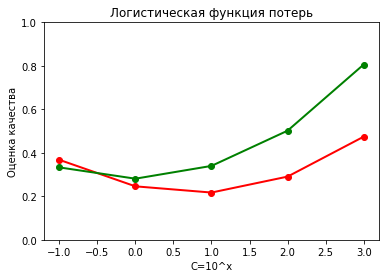

In [7]:
plt.plot([i for i in range(-1, 4)],[x[0] for x in cv_score],  'go-', 
         label='line 1', linewidth = 2, color = 'red')
plt.plot([i for i in range(-1, 4)], [x[0] for x in test_score],  'go-', 
         label='line 1', linewidth = 2, color = 'green')
plt.ylim(0, 1)
plt.ylabel('Оценка качества')
plt.xlabel('C=10^x')
plt.title('Логистическая функция потерь')

Text(0.5, 1.0, 'Точность')

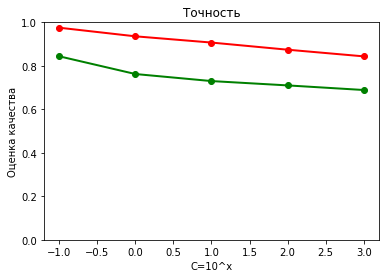

In [8]:
plt.plot([i for i in range(-1, 4)],[x[1] for x in cv_score],  'go-', 
         label='line 1', linewidth = 2, color = 'red')
plt.plot([i for i in range(-1, 4)], [x[1] for x in test_score],  'go-', 
         label='line 1', linewidth = 2, color = 'green')
plt.ylim(0, 1)
plt.ylabel('Оценка качества')
plt.xlabel('C=10^x')
plt.title('Точность')

Text(0.5, 1.0, 'ROC-AUC')

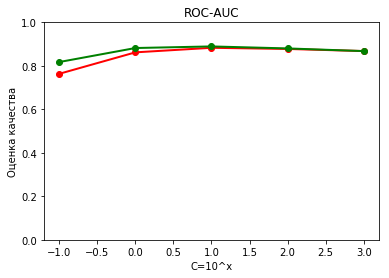

In [9]:
plt.plot([i for i in range(-1, 4)],[x[2] for x in cv_score],  'go-', 
         label='line 1', linewidth = 2, color = 'red')
plt.plot([i for i in range(-1, 4)], [x[2] for x in test_score],  'go-', 
         label='line 1', linewidth = 2, color = 'green')
plt.ylim(0, 1)
plt.ylabel('Оценка качества')
plt.xlabel('C=10^x')
plt.title('ROC-AUC')

In [10]:
cv_scores = pd.DataFrame( index=C, columns=['ROC-AUC', 'Precision', 'Log loss'])
cv_scores['ROC-AUC'] = [round(x[2], 6) for x in cv_score]
cv_scores['Log loss'] =  [round(x[0], 6) for x in cv_score]
cv_scores['Precision'] =  [round(x[1], 6) for x in cv_score]
cv_scores.to_csv('scores_cv.csv')

In [11]:
test_scores = pd.DataFrame( index=C, columns=['ROC-AUC', 'Precision', 'Log loss'])
test_scores['ROC-AUC'] = [round(x[2], 6) for x in test_score]
test_scores['Log loss'] =  [round(x[0], 6) for x in test_score]
test_scores['Precision'] =  [round(x[1], 6) for x in test_score]
test_scores.to_csv('scores_test.csv')